![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/logo_MCV_W.png)

## **Train a Shapes Mask CNN**

---



### **Setup and install required packages**

In [1]:
!pip uninstall tensorflow --yes
!pip install tensorflow-gpu==1.13.1
%tensorflow_version 1.x
import tensorflow
print(tensorflow.version)
!pip uninstall keras-nightly --yes
!pip uninstall keras --yes
!pip install h5py==2.10.0
!pip install q keras==2.1.0

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Successfully uninstalled tensorflow-2.7.0
     |████████████████████████████████| 345.0 MB 4.0 kB/s 
     |████████████████████████████████| 50 kB 9.0 MB/s 
     |████████████████████████████████| 3.2 MB 52.3 MB/s 
     |████████████████████████████████| 367 kB 72.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
TensorFlow 1.x selected.
<module 'tensorflow._api.v1.version' from '/tensorflow-1.15.2/python3.7/tensorflow_core/_api/v1/version/__init__.py'>
Found existing installation: Keras 2.3.1
Uninstalling Keras-2.3.1:
  Successfully uninstalled Keras-2.3.1
     |█████████████

     |████████████████████████████████| 302 kB 15.5 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


In [1]:
!pip uninstall h5py -y
!pip install h5py==2.10.0
!pip3 install keras==2.1.0

Found existing installation: h5py 2.10.0
Uninstalling h5py-2.10.0:
  Successfully uninstalled h5py-2.10.0
  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 13.59 MiB/s, done.
Resolving deltas: 100% (565/565), done.


In [4]:
%cd Mask_RCNN/samples/shapes/

/content/Mask_RCNN/samples/shapes


## **Mask R-CNN - Train on Shapes Dataset**
This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the Shapes dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster.

In [5]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


... done downloading pretrained model!


## **Configurations**

In [6]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

### **Notebook preferences**

In [7]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## **Dataset**

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, load_shapes(), and override the following methods:

- load_image()
- load_mask()
- image_reference()

In [8]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [9]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

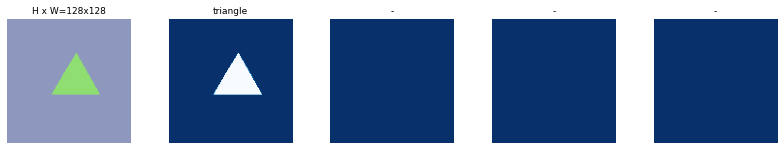

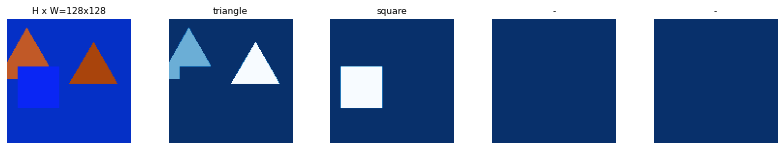

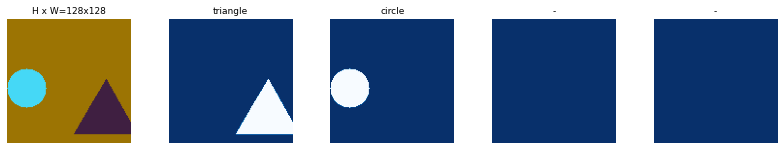

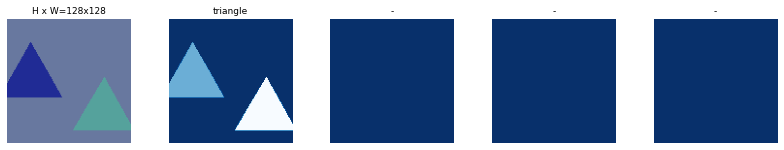

In [10]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## **Create Model**

In [11]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [12]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## **Training**

Train in two stages:

- Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.
- Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.

In [15]:
#!python3 setup.py install 

In [14]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/shapes20220129T1935/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
 

Epoch 1/1


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 34:00 - loss: 6.7581 - rpn_class_loss: 0.0835 - rpn_bbox_loss: 1.7804 - mrcnn_class_loss: 2.7838 - mrcnn_bbox_loss: 1.1342 - mrcnn_mask_loss: 0.9763

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 17:05 - loss: 6.4975 - rpn_class_loss: 0.0879 - rpn_bbox_loss: 1.9304 - mrcnn_class_loss: 2.4117 - mrcnn_bbox_loss: 1.0961 - mrcnn_mask_loss: 0.9715

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 11:25 - loss: 6.5230 - rpn_class_loss: 0.0865 - rpn_bbox_loss: 2.2856 - mrcnn_class_loss: 1.9966 - mrcnn_bbox_loss: 1.0784 - mrcnn_mask_loss: 1.0758

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 8:35 - loss: 6.1491 - rpn_class_loss: 0.0840 - rpn_bbox_loss: 2.1259 - mrcnn_class_loss: 1.7688 - mrcnn_bbox_loss: 1.0824 - mrcnn_mask_loss: 1.0881 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/100 [>.............................] - ETA: 6:53 - loss: 5.8933 - rpn_class_loss: 0.0870 - rpn_bbox_loss: 2.0820 - mrcnn_class_loss: 1.6627 - mrcnn_bbox_loss: 1.0439 - mrcnn_mask_loss: 1.0176

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 5:45 - loss: 5.5254 - rpn_class_loss: 0.0843 - rpn_bbox_loss: 1.8833 - mrcnn_class_loss: 1.5440 - mrcnn_bbox_loss: 1.0165 - mrcnn_mask_loss: 0.9973

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/100 [=>............................] - ETA: 4:56 - loss: 5.2431 - rpn_class_loss: 0.0806 - rpn_bbox_loss: 1.7972 - mrcnn_class_loss: 1.4084 - mrcnn_bbox_loss: 1.0027 - mrcnn_mask_loss: 0.9541

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/100 [=>............................] - ETA: 4:19 - loss: 5.0636 - rpn_class_loss: 0.0829 - rpn_bbox_loss: 1.7397 - mrcnn_class_loss: 1.3390 - mrcnn_bbox_loss: 0.9769 - mrcnn_mask_loss: 0.9252

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  9/100 [=>............................] - ETA: 3:51 - loss: 4.9344 - rpn_class_loss: 0.0848 - rpn_bbox_loss: 1.6952 - mrcnn_class_loss: 1.3189 - mrcnn_bbox_loss: 0.9495 - mrcnn_mask_loss: 0.8861

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 10/100 [==>...........................] - ETA: 3:27 - loss: 4.7345 - rpn_class_loss: 0.0821 - rpn_bbox_loss: 1.6113 - mrcnn_class_loss: 1.2515 - mrcnn_bbox_loss: 0.9323 - mrcnn_mask_loss: 0.8573

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/100 [==>...........................] - ETA: 3:09 - loss: 4.5923 - rpn_class_loss: 0.0792 - rpn_bbox_loss: 1.5449 - mrcnn_class_loss: 1.2123 - mrcnn_bbox_loss: 0.9197 - mrcnn_mask_loss: 0.8362

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 2:53 - loss: 4.4997 - rpn_class_loss: 0.0792 - rpn_bbox_loss: 1.4954 - mrcnn_class_loss: 1.2012 - mrcnn_bbox_loss: 0.9099 - mrcnn_mask_loss: 0.8140

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 2:39 - loss: 4.3752 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 1.4477 - mrcnn_class_loss: 1.1674 - mrcnn_bbox_loss: 0.8905 - mrcnn_mask_loss: 0.7926

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 2:28 - loss: 4.2735 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 1.4119 - mrcnn_class_loss: 1.1331 - mrcnn_bbox_loss: 0.8785 - mrcnn_mask_loss: 0.7723

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 2:18 - loss: 4.1703 - rpn_class_loss: 0.0772 - rpn_bbox_loss: 1.3753 - mrcnn_class_loss: 1.0998 - mrcnn_bbox_loss: 0.8619 - mrcnn_mask_loss: 0.7561

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 2:09 - loss: 4.0516 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 1.3329 - mrcnn_class_loss: 1.0659 - mrcnn_bbox_loss: 0.8427 - mrcnn_mask_loss: 0.7350

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 2:02 - loss: 3.9537 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 1.2957 - mrcnn_class_loss: 1.0325 - mrcnn_bbox_loss: 0.8302 - mrcnn_mask_loss: 0.7207

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 1:55 - loss: 3.8809 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 1.2657 - mrcnn_class_loss: 1.0153 - mrcnn_bbox_loss: 0.8183 - mrcnn_mask_loss: 0.7072

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 19/100 [====>.........................] - ETA: 1:48 - loss: 3.8283 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 1.2412 - mrcnn_class_loss: 1.0114 - mrcnn_bbox_loss: 0.8057 - mrcnn_mask_loss: 0.6963

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 20/100 [=====>........................] - ETA: 1:43 - loss: 3.7527 - rpn_class_loss: 0.0734 - rpn_bbox_loss: 1.2061 - mrcnn_class_loss: 0.9923 - mrcnn_bbox_loss: 0.7949 - mrcnn_mask_loss: 0.6861

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 21/100 [=====>........................] - ETA: 1:37 - loss: 3.6840 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.1826 - mrcnn_class_loss: 0.9657 - mrcnn_bbox_loss: 0.7863 - mrcnn_mask_loss: 0.6773

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 22/100 [=====>........................] - ETA: 1:33 - loss: 3.6153 - rpn_class_loss: 0.0713 - rpn_bbox_loss: 1.1653 - mrcnn_class_loss: 0.9399 - mrcnn_bbox_loss: 0.7735 - mrcnn_mask_loss: 0.6653

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 23/100 [=====>........................] - ETA: 1:29 - loss: 3.5485 - rpn_class_loss: 0.0701 - rpn_bbox_loss: 1.1422 - mrcnn_class_loss: 0.9172 - mrcnn_bbox_loss: 0.7636 - mrcnn_mask_loss: 0.6554

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 24/100 [======>.......................] - ETA: 1:25 - loss: 3.5010 - rpn_class_loss: 0.0698 - rpn_bbox_loss: 1.1347 - mrcnn_class_loss: 0.8983 - mrcnn_bbox_loss: 0.7525 - mrcnn_mask_loss: 0.6457

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 25/100 [======>.......................] - ETA: 1:21 - loss: 3.4448 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 1.1180 - mrcnn_class_loss: 0.8814 - mrcnn_bbox_loss: 0.7400 - mrcnn_mask_loss: 0.6359

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 26/100 [======>.......................] - ETA: 1:18 - loss: 3.3866 - rpn_class_loss: 0.0685 - rpn_bbox_loss: 1.0980 - mrcnn_class_loss: 0.8642 - mrcnn_bbox_loss: 0.7289 - mrcnn_mask_loss: 0.6270

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 27/100 [=======>......................] - ETA: 1:15 - loss: 3.3349 - rpn_class_loss: 0.0676 - rpn_bbox_loss: 1.0749 - mrcnn_class_loss: 0.8501 - mrcnn_bbox_loss: 0.7204 - mrcnn_mask_loss: 0.6219

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 28/100 [=======>......................] - ETA: 1:12 - loss: 3.2819 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 1.0552 - mrcnn_class_loss: 0.8326 - mrcnn_bbox_loss: 0.7122 - mrcnn_mask_loss: 0.6147

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 29/100 [=======>......................] - ETA: 1:09 - loss: 3.2313 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 1.0404 - mrcnn_class_loss: 0.8163 - mrcnn_bbox_loss: 0.7020 - mrcnn_mask_loss: 0.6063

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 30/100 [========>.....................] - ETA: 1:06 - loss: 3.1798 - rpn_class_loss: 0.0653 - rpn_bbox_loss: 1.0218 - mrcnn_class_loss: 0.8004 - mrcnn_bbox_loss: 0.6923 - mrcnn_mask_loss: 0.6000

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 31/100 [========>.....................] - ETA: 1:04 - loss: 3.1314 - rpn_class_loss: 0.0643 - rpn_bbox_loss: 1.0080 - mrcnn_class_loss: 0.7840 - mrcnn_bbox_loss: 0.6835 - mrcnn_mask_loss: 0.5917

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 32/100 [========>.....................] - ETA: 1:01 - loss: 3.0872 - rpn_class_loss: 0.0632 - rpn_bbox_loss: 0.9940 - mrcnn_class_loss: 0.7696 - mrcnn_bbox_loss: 0.6755 - mrcnn_mask_loss: 0.5848

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 33/100 [========>.....................] - ETA: 59s - loss: 3.0440 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.9789 - mrcnn_class_loss: 0.7571 - mrcnn_bbox_loss: 0.6677 - mrcnn_mask_loss: 0.5782 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 34/100 [=========>....................] - ETA: 57s - loss: 3.0000 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 0.9642 - mrcnn_class_loss: 0.7436 - mrcnn_bbox_loss: 0.6593 - mrcnn_mask_loss: 0.5714

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 35/100 [=========>....................] - ETA: 55s - loss: 2.9641 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 0.9551 - mrcnn_class_loss: 0.7326 - mrcnn_bbox_loss: 0.6505 - mrcnn_mask_loss: 0.5650

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 36/100 [=========>....................] - ETA: 53s - loss: 2.9266 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 0.9387 - mrcnn_class_loss: 0.7219 - mrcnn_bbox_loss: 0.6467 - mrcnn_mask_loss: 0.5592

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 37/100 [==========>...................] - ETA: 51s - loss: 2.8878 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 0.9291 - mrcnn_class_loss: 0.7085 - mrcnn_bbox_loss: 0.6387 - mrcnn_mask_loss: 0.5526

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 38/100 [==========>...................] - ETA: 50s - loss: 2.8545 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 0.9166 - mrcnn_class_loss: 0.6983 - mrcnn_bbox_loss: 0.6332 - mrcnn_mask_loss: 0.5484

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 39/100 [==========>...................] - ETA: 48s - loss: 2.8193 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 0.9088 - mrcnn_class_loss: 0.6868 - mrcnn_bbox_loss: 0.6246 - mrcnn_mask_loss: 0.5419

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 40/100 [===========>..................] - ETA: 47s - loss: 2.7875 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 0.8979 - mrcnn_class_loss: 0.6792 - mrcnn_bbox_loss: 0.6181 - mrcnn_mask_loss: 0.5359

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 41/100 [===========>..................] - ETA: 45s - loss: 2.7543 - rpn_class_loss: 0.0555 - rpn_bbox_loss: 0.8895 - mrcnn_class_loss: 0.6694 - mrcnn_bbox_loss: 0.6116 - mrcnn_mask_loss: 0.5284

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 42/100 [===========>..................] - ETA: 44s - loss: 2.7219 - rpn_class_loss: 0.0547 - rpn_bbox_loss: 0.8828 - mrcnn_class_loss: 0.6586 - mrcnn_bbox_loss: 0.6043 - mrcnn_mask_loss: 0.5214

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 43/100 [===========>..................] - ETA: 42s - loss: 2.6877 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 0.8703 - mrcnn_class_loss: 0.6488 - mrcnn_bbox_loss: 0.5988 - mrcnn_mask_loss: 0.5157

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 44/100 [============>.................] - ETA: 41s - loss: 2.6597 - rpn_class_loss: 0.0533 - rpn_bbox_loss: 0.8647 - mrcnn_class_loss: 0.6401 - mrcnn_bbox_loss: 0.5918 - mrcnn_mask_loss: 0.5098

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 45/100 [============>.................] - ETA: 40s - loss: 2.6263 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 0.8551 - mrcnn_class_loss: 0.6309 - mrcnn_bbox_loss: 0.5844 - mrcnn_mask_loss: 0.5033

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 46/100 [============>.................] - ETA: 38s - loss: 2.5958 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 0.8474 - mrcnn_class_loss: 0.6226 - mrcnn_bbox_loss: 0.5765 - mrcnn_mask_loss: 0.4974

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 47/100 [=============>................] - ETA: 37s - loss: 2.5663 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 0.8413 - mrcnn_class_loss: 0.6140 - mrcnn_bbox_loss: 0.5689 - mrcnn_mask_loss: 0.4909

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 48/100 [=============>................] - ETA: 36s - loss: 2.5408 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 0.8349 - mrcnn_class_loss: 0.6074 - mrcnn_bbox_loss: 0.5624 - mrcnn_mask_loss: 0.4855

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 49/100 [=============>................] - ETA: 35s - loss: 2.5186 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 0.8296 - mrcnn_class_loss: 0.6012 - mrcnn_bbox_loss: 0.5579 - mrcnn_mask_loss: 0.4799

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 50/100 [==============>...............] - ETA: 34s - loss: 2.4877 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 0.8209 - mrcnn_class_loss: 0.5926 - mrcnn_bbox_loss: 0.5506 - mrcnn_mask_loss: 0.4743

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 51/100 [==============>...............] - ETA: 33s - loss: 2.4608 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 0.8136 - mrcnn_class_loss: 0.5864 - mrcnn_bbox_loss: 0.5440 - mrcnn_mask_loss: 0.4682

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 52/100 [==============>...............] - ETA: 32s - loss: 2.4358 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 0.8058 - mrcnn_class_loss: 0.5799 - mrcnn_bbox_loss: 0.5388 - mrcnn_mask_loss: 0.4634

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 53/100 [==============>...............] - ETA: 31s - loss: 2.4181 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.7989 - mrcnn_class_loss: 0.5761 - mrcnn_bbox_loss: 0.5363 - mrcnn_mask_loss: 0.4595

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 54/100 [===============>..............] - ETA: 30s - loss: 2.3969 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 0.7932 - mrcnn_class_loss: 0.5697 - mrcnn_bbox_loss: 0.5331 - mrcnn_mask_loss: 0.4542

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 55/100 [===============>..............] - ETA: 29s - loss: 2.3761 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.7878 - mrcnn_class_loss: 0.5641 - mrcnn_bbox_loss: 0.5282 - mrcnn_mask_loss: 0.4498

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 56/100 [===============>..............] - ETA: 28s - loss: 2.3586 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 0.7824 - mrcnn_class_loss: 0.5582 - mrcnn_bbox_loss: 0.5245 - mrcnn_mask_loss: 0.4478

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 57/100 [================>.............] - ETA: 27s - loss: 2.3389 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 0.7753 - mrcnn_class_loss: 0.5545 - mrcnn_bbox_loss: 0.5202 - mrcnn_mask_loss: 0.4438

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 58/100 [================>.............] - ETA: 26s - loss: 2.3164 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 0.7697 - mrcnn_class_loss: 0.5478 - mrcnn_bbox_loss: 0.5152 - mrcnn_mask_loss: 0.4389

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 59/100 [================>.............] - ETA: 25s - loss: 2.2981 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 0.7663 - mrcnn_class_loss: 0.5413 - mrcnn_bbox_loss: 0.5113 - mrcnn_mask_loss: 0.4350

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 60/100 [=================>............] - ETA: 24s - loss: 2.2768 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 0.7598 - mrcnn_class_loss: 0.5361 - mrcnn_bbox_loss: 0.5061 - mrcnn_mask_loss: 0.4309

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 61/100 [=================>............] - ETA: 23s - loss: 2.2557 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 0.7558 - mrcnn_class_loss: 0.5292 - mrcnn_bbox_loss: 0.5012 - mrcnn_mask_loss: 0.4261

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 62/100 [=================>............] - ETA: 23s - loss: 2.2361 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 0.7502 - mrcnn_class_loss: 0.5239 - mrcnn_bbox_loss: 0.4963 - mrcnn_mask_loss: 0.4228

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 63/100 [=================>............] - ETA: 22s - loss: 2.2156 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.7448 - mrcnn_class_loss: 0.5186 - mrcnn_bbox_loss: 0.4916 - mrcnn_mask_loss: 0.4181

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 64/100 [==================>...........] - ETA: 21s - loss: 2.1986 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 0.7405 - mrcnn_class_loss: 0.5135 - mrcnn_bbox_loss: 0.4872 - mrcnn_mask_loss: 0.4151

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 65/100 [==================>...........] - ETA: 20s - loss: 2.1806 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.7366 - mrcnn_class_loss: 0.5081 - mrcnn_bbox_loss: 0.4832 - mrcnn_mask_loss: 0.4110

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 66/100 [==================>...........] - ETA: 19s - loss: 2.1669 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.7339 - mrcnn_class_loss: 0.5037 - mrcnn_bbox_loss: 0.4801 - mrcnn_mask_loss: 0.4077

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 67/100 [===================>..........] - ETA: 19s - loss: 2.1479 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 0.7293 - mrcnn_class_loss: 0.4979 - mrcnn_bbox_loss: 0.4761 - mrcnn_mask_loss: 0.4035

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 68/100 [===================>..........] - ETA: 18s - loss: 2.1316 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 0.7246 - mrcnn_class_loss: 0.4934 - mrcnn_bbox_loss: 0.4727 - mrcnn_mask_loss: 0.4000

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 69/100 [===================>..........] - ETA: 17s - loss: 2.1154 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.7219 - mrcnn_class_loss: 0.4884 - mrcnn_bbox_loss: 0.4682 - mrcnn_mask_loss: 0.3962

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 70/100 [====================>.........] - ETA: 17s - loss: 2.0995 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 0.7174 - mrcnn_class_loss: 0.4839 - mrcnn_bbox_loss: 0.4646 - mrcnn_mask_loss: 0.3932

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 71/100 [====================>.........] - ETA: 16s - loss: 2.0839 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.7152 - mrcnn_class_loss: 0.4787 - mrcnn_bbox_loss: 0.4606 - mrcnn_mask_loss: 0.3894

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 72/100 [====================>.........] - ETA: 15s - loss: 2.0712 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.7119 - mrcnn_class_loss: 0.4751 - mrcnn_bbox_loss: 0.4579 - mrcnn_mask_loss: 0.3865

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 73/100 [====================>.........] - ETA: 15s - loss: 2.0586 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.7089 - mrcnn_class_loss: 0.4717 - mrcnn_bbox_loss: 0.4547 - mrcnn_mask_loss: 0.3839

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 74/100 [=====================>........] - ETA: 14s - loss: 2.0419 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.7031 - mrcnn_class_loss: 0.4678 - mrcnn_bbox_loss: 0.4511 - mrcnn_mask_loss: 0.3807

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 75/100 [=====================>........] - ETA: 13s - loss: 2.0294 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.7000 - mrcnn_class_loss: 0.4648 - mrcnn_bbox_loss: 0.4480 - mrcnn_mask_loss: 0.3777

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 76/100 [=====================>........] - ETA: 13s - loss: 2.0156 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.6970 - mrcnn_class_loss: 0.4609 - mrcnn_bbox_loss: 0.4444 - mrcnn_mask_loss: 0.3745

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 77/100 [======================>.......] - ETA: 12s - loss: 2.0037 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.6946 - mrcnn_class_loss: 0.4574 - mrcnn_bbox_loss: 0.4416 - mrcnn_mask_loss: 0.3717

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 78/100 [======================>.......] - ETA: 11s - loss: 1.9906 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.6917 - mrcnn_class_loss: 0.4535 - mrcnn_bbox_loss: 0.4388 - mrcnn_mask_loss: 0.3683

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 79/100 [======================>.......] - ETA: 11s - loss: 1.9824 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.6873 - mrcnn_class_loss: 0.4540 - mrcnn_bbox_loss: 0.4363 - mrcnn_mask_loss: 0.3669

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 80/100 [=======================>......] - ETA: 10s - loss: 1.9749 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.6851 - mrcnn_class_loss: 0.4514 - mrcnn_bbox_loss: 0.4358 - mrcnn_mask_loss: 0.3650

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 81/100 [=======================>......] - ETA: 10s - loss: 1.9655 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6820 - mrcnn_class_loss: 0.4495 - mrcnn_bbox_loss: 0.4330 - mrcnn_mask_loss: 0.3635

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 82/100 [=======================>......] - ETA: 9s - loss: 1.9520 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.6782 - mrcnn_class_loss: 0.4463 - mrcnn_bbox_loss: 0.4299 - mrcnn_mask_loss: 0.3605 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 83/100 [=======================>......] - ETA: 8s - loss: 1.9427 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.6758 - mrcnn_class_loss: 0.4428 - mrcnn_bbox_loss: 0.4277 - mrcnn_mask_loss: 0.3595

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 84/100 [========================>.....] - ETA: 8s - loss: 1.9314 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.6718 - mrcnn_class_loss: 0.4397 - mrcnn_bbox_loss: 0.4251 - mrcnn_mask_loss: 0.3581

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 85/100 [========================>.....] - ETA: 7s - loss: 1.9226 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.6698 - mrcnn_class_loss: 0.4366 - mrcnn_bbox_loss: 0.4233 - mrcnn_mask_loss: 0.3564

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 86/100 [========================>.....] - ETA: 7s - loss: 1.9112 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.6670 - mrcnn_class_loss: 0.4337 - mrcnn_bbox_loss: 0.4205 - mrcnn_mask_loss: 0.3539

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 87/100 [=========================>....] - ETA: 6s - loss: 1.8999 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.6633 - mrcnn_class_loss: 0.4309 - mrcnn_bbox_loss: 0.4182 - mrcnn_mask_loss: 0.3515

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 88/100 [=========================>....] - ETA: 6s - loss: 1.8896 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.6606 - mrcnn_class_loss: 0.4279 - mrcnn_bbox_loss: 0.4157 - mrcnn_mask_loss: 0.3497

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 89/100 [=========================>....] - ETA: 5s - loss: 1.8783 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.6580 - mrcnn_class_loss: 0.4246 - mrcnn_bbox_loss: 0.4127 - mrcnn_mask_loss: 0.3475

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 90/100 [==========================>...] - ETA: 5s - loss: 1.8678 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.6547 - mrcnn_class_loss: 0.4222 - mrcnn_bbox_loss: 0.4100 - mrcnn_mask_loss: 0.3455

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 91/100 [==========================>...] - ETA: 4s - loss: 1.8570 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.6516 - mrcnn_class_loss: 0.4189 - mrcnn_bbox_loss: 0.4080 - mrcnn_mask_loss: 0.3434

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 92/100 [==========================>...] - ETA: 4s - loss: 1.8504 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.6501 - mrcnn_class_loss: 0.4176 - mrcnn_bbox_loss: 0.4063 - mrcnn_mask_loss: 0.3415

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 93/100 [==========================>...] - ETA: 3s - loss: 1.8397 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.6472 - mrcnn_class_loss: 0.4147 - mrcnn_bbox_loss: 0.4038 - mrcnn_mask_loss: 0.3395

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 94/100 [===========================>..] - ETA: 2s - loss: 1.8295 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.6441 - mrcnn_class_loss: 0.4125 - mrcnn_bbox_loss: 0.4013 - mrcnn_mask_loss: 0.3371

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 95/100 [===========================>..] - ETA: 2s - loss: 1.8197 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.6417 - mrcnn_class_loss: 0.4099 - mrcnn_bbox_loss: 0.3991 - mrcnn_mask_loss: 0.3348

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 96/100 [===========================>..] - ETA: 1s - loss: 1.8112 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.6403 - mrcnn_class_loss: 0.4076 - mrcnn_bbox_loss: 0.3967 - mrcnn_mask_loss: 0.3324

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 97/100 [============================>.] - ETA: 1s - loss: 1.8004 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.6368 - mrcnn_class_loss: 0.4049 - mrcnn_bbox_loss: 0.3943 - mrcnn_mask_loss: 0.3306

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 98/100 [============================>.] - ETA: 0s - loss: 1.7934 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.6360 - mrcnn_class_loss: 0.4031 - mrcnn_bbox_loss: 0.3919 - mrcnn_mask_loss: 0.3287

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 99/100 [============================>.] - ETA: 0s - loss: 1.7847 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.6340 - mrcnn_class_loss: 0.4011 - mrcnn_bbox_loss: 0.3898 - mrcnn_mask_loss: 0.3264

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 


100/100 [==============================] - 132s 1s/step - loss: 1.7761 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.6318 - mrcnn_class_loss: 0.3994 - mrcnn_bbox_loss: 0.3874 - mrcnn_mask_loss: 0.3242 - val_loss: 1.0748 - val_rpn_class_loss: 0.0182 - val_rpn_bbox_loss: 0.4926 - val_mrcnn_class_loss: 0.2396 - val_mrcnn_bbox_loss: 0.1851 - val_mrcnn_mask_loss: 0.1392


## **Detection**

In [16]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/Mask_RCNN/logs/shapes20220129T1935/mask_rcnn_shapes_0001.h5
Re-starting from epoch 1


original_image           shape: (128, 128, 3)         min:   33.00000  max:  248.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int64
gt_class_id              shape: (3,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (3, 4)                min:    2.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 3)         min:    0.00000  max:    1.00000  bool


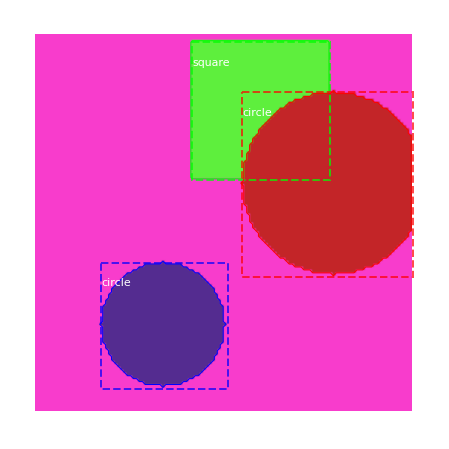

In [17]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:   33.00000  max:  248.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:  -70.90000  max:  124.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


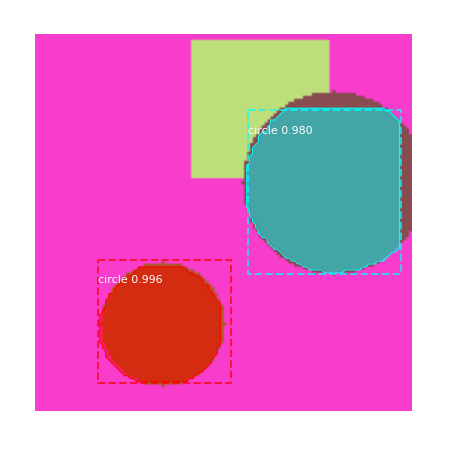

In [18]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## **Evaluation**

In [19]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.8583333373069764
